In [ ]:
import logging
import torch
import pprint

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import pandas as pd
import numpy as np

from neural_bandits.bandits.neural_ucb_bandit import NeuralUCBBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset
from neural_bandits.utils.data_storage import InMemoryDataBuffer, AllDataBufferStrategy
from neural_bandits.utils.data_sampler import RandomDataSampler
from neural_bandits.utils.selectors import EpsilonGreedySelector

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size, hidden_size=100)
selector = EpsilonGreedySelector(epsilon=0.1, seed=42)

accelerator = "cpu"
batch_size = 1
n_samples = 10000

indices = list(range(len(dataset)))
random.shuffle(indices)
subset_indices = indices[:n_samples]
mini_dataset = Subset(dataset, subset_indices)
print("Subset size:", len(mini_dataset))
sorted_sampler = RandomDataSampler(
    data_source=Subset(dataset, range(n_samples)),
)

7840
70000
Subset size: 10000


In [4]:
buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=n_samples,
    device=accelerator,
)

In [ ]:
accelerator = "cpu"

train_loader = DataLoader(Subset(dataset, range(n_samples)), sampler=sorted_sampler, batch_size=256)
env = BanditBenchmarkEnvironment(train_loader, device=accelerator)
bandit_module = NeuralUCBBandit(
    n_features=dataset.context_size,
    network=network,
    buffer=buffer,
    train_batch_size=32,
    early_stop_threshold=1e-3,
    weight_decay=1e-3,
    exploration_rate=1e-5,
    learning_rate=1e-3,
    min_samples_required_for_training=1024,
    initial_train_steps=2048,
).to(accelerator)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(
    CSVLogger(
        "logs", name="neural_ucb_bandit", flush_logs_every_n_steps=100
    ),
    enable_console_logging=False
)

In [ ]:
rewards = np.array([])
regrets = np.array([])
progress_bar = tqdm(iter(env), total=len(env))
for contextualized_actions in progress_bar:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(
        max_epochs=1,
        max_steps=1000,
        logger=logger,
        gradient_clip_val=20.0,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=True,
        accelerator=accelerator,
    )
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())
    
    progress_bar.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=regrets.mean(),
    )

    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards)
    trainer.fit(bandit_module)
metrics = pd.DataFrame({
    "reward": rewards,
    "regret": regrets,
})
metrics

In [ ]:
checkpoint_path = logger._logger_wrappee.log_dir + "/bandit_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)
print(f"Model saved to {checkpoint_path}")

Model saved to logs\neural_ucb_bandit\version_13/bandit_checkpoint.ckpt


In [9]:
checkpoint = torch.load(checkpoint_path, map_location=accelerator)

print("Top-level keys in checkpoint:")
print(list(checkpoint.keys()))

pp = pprint.PrettyPrinter(indent=4)

print("\nHyperparameters:")
pp.pprint(checkpoint.get('hyper_parameters', {}))

print("\nModel state_dict keys:")
if 'state_dict' in checkpoint:
    pp.pprint(list(checkpoint['state_dict'].keys()))

print("\nOptimizer state:")
if 'optimizer_states' in checkpoint:
    pp.pprint(checkpoint['optimizer_states'][0].keys())

print("\nBuffer state:")
if 'buffer_state' in checkpoint:
    pp.pprint(checkpoint['buffer_state'])

print("\nSelector type:")
if 'selector_type' in checkpoint:
    pp.pprint(checkpoint['selector_type'])

print("\nZ_t tensor shape:")
if 'Z_t' in checkpoint:
    pp.pprint(checkpoint['Z_t'].shape)

Top-level keys in checkpoint:
['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'buffer_state', 'Z_t', 'selector_type', 'network_state', '_trained_once']

Hyperparameters:
{   'early_stop_threshold': 0.001,
    'initial_train_steps': 2000,
    'lambda_': 1e-05,
    'learning_rate': 0.0001,
    'max_grad_norm': 20.0,
    'n_features': 7840,
    'nu': 1e-05,
    'num_grad_steps': 1000,
    'train_batch_size': 1,
    'train_interval': 100}

Model state_dict keys:
[   'Z_t',
    'theta_t.fc1.weight',
    'theta_t.fc1.bias',
    'theta_t.fc2.weight',
    'theta_t.fc2.bias']

Optimizer state:
dict_keys(['state', 'param_groups'])

Buffer state:
{   'buffer_strategy': <neural_bandits.utils.data_storage.AllDataBufferStrategy object at 0x00000190FC25F1C0>,
    'contextualized_actions': tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]]),
    'embedded

C:\Users\Parisa\AppData\Local\Temp\ipykernel_23224\4289924043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=accel

In [10]:
checkpoint_path = "logs\\neural_ucb_bandit\\version_12/bandit_checkpoint.ckpt"

loaded_bandit = NeuralUCBBandit.load_from_checkpoint(
    checkpoint_path,
    n_features=dataset.context_size,
    network=network,
    buffer=buffer,
)
print("Model loaded successfully!")

Model loaded successfully!


In [11]:
context, label = dataset[random.randint(0, len(dataset) - 1)]
contextualized_actions = context.unsqueeze(0)

chosen_actions, _ = loaded_bandit(contextualized_actions)
predicted_arm = chosen_actions.argmax(dim=1).item()

true_arm = label.argmax().item() if isinstance(label, torch.Tensor) else label

print(f"True best action/arm: {true_arm}")
print(f"Model predicted action/arm: {predicted_arm}")
print(f"Correct prediction: {true_arm == predicted_arm}")
print(f"Full model prediction: {chosen_actions}")

True best action/arm: 5
Model predicted action/arm: 5
Correct prediction: True
Full model prediction: tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


In [13]:
# load metrics from the logger and plot
import numpy as np

# metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
metrics_csv = "logs\\neural_ucb_bandit\\version_12\\metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:10000])
cumulative_regret = np.cumsum(metrics["regret"][:10000])

logs\neural_ucb_bandit\version_12\metrics.csv


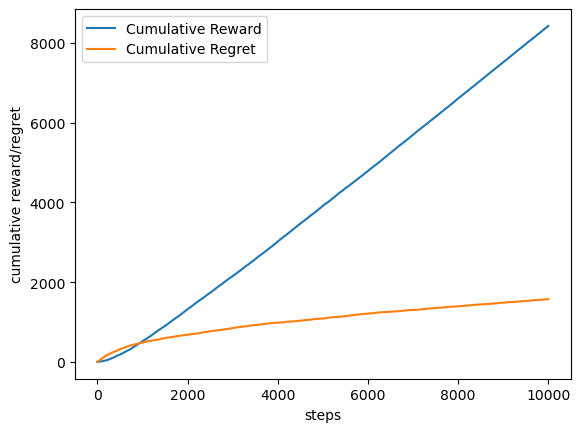

In [14]:
import matplotlib.pyplot as plt

plt.plot(cumulative_reward, label="Cumulative Reward")
plt.plot(cumulative_regret, label="Cumulative Regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [15]:
# average reward
print(sum(metrics["reward"][:10]) / 10)
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:10].dropna()) / 10)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:10000].dropna()) / 10000)

0.2
0.15
0.8427
0.8
0.85
0.1573


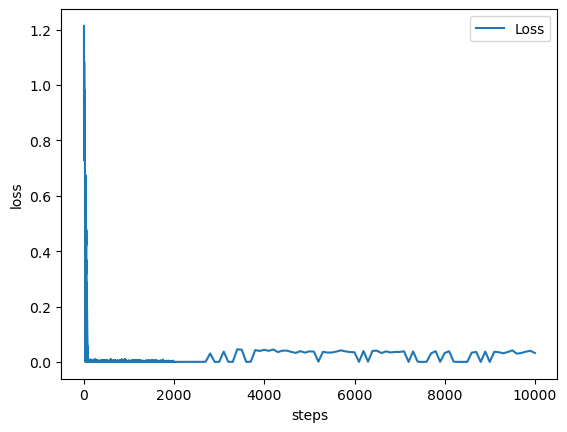

In [16]:
bandit_metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(bandit_metrics_csv)
bandit_metrics = pd.read_csv(bandit_metrics_csv)

plt.plot(bandit_metrics["loss"][:10000].dropna(), label="Loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()